## Les prérequis:
- numpy
- matplotlib
- tqdm
- scipy
- opencv-python
- torch
- torchvision

## Les imports 

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import cv2 as cv
from scipy.spatial.distance import cdist
import os

## Lire et organiser les chemins

In [21]:
folder_name = "smallholidays"
names = os.listdir(folder_name)
img_dict = {}
answers = []
for name in names:
    if name[4:6] == '00':
        if name not in img_dict:
            img_dict[name] = []
    else:
        answers.append(name)
        for q in img_dict.keys():
            if q[:5] == name[:5]:
                img_dict[q].append(name)

queries = list(img_dict.keys())
print('Le nombre d\'images requetes : {}'.format(len(img_dict)))
print('Le nombre d\'images reponses : {}'.format(len(answers)))
print('Le nombre d\'images au total est : {}'.format(len(names)))
print("Si la requete est l'image {}, ces images correspendantes sont {}".format(names[0], img_dict[names[0]]))

Le nombre d'images requetes : 500
Le nombre d'images reponses : 991
Le nombre d'images au total est : 1491
Si la requete est l'image 100000.jpg, ces images correspendantes sont ['100001.jpg', '100002.jpg']


## Implementer un system de search d'image simple

In [31]:
def compute_sim(name1, name2, size, metric):
    img1 = plt.imread(os.path.join(folder_name, name1))
    img2 = plt.imread(os.path.join(folder_name, name2))

    img1 = cv.resize(img1, (size, size))
    img2 = cv.resize(img2, (size, size))

    flattend1 = img1.flatten().reshape((1, size**2*3))
    flattend2 = img2.flatten().reshape((1, size**2*3))

    sim = 1 - cdist(flattend1, flattend2, metric=metric)
    return sim.ravel()


def retreive_images(query, number, size, metric):
    similarities = []
    for name in tqdm(answers):
        similarities.append((name, compute_sim(query, name, size, metric)))
    sorted_sim = sorted(similarities, key = lambda x: x[1], reverse=True)
    
    plt.imshow(plt.imread(os.path.join(folder_name, query)))
    plt.title("Query : {}".format(query))
    plt.show()
    
    print("################################# Les vraies réponses ###########################")
    gt = img_dict[query]
    n = len(gt)
    plt.figure(figsize=(4*n,6))
    for i in range(n):
        plt.subplot(1,n,i+1)
        plt.title(gt[i])
        plt.imshow(plt.imread(os.path.join(folder_name, gt[i])))
    plt.show()
    
    print("################################# Les images retrouvées ################################")
    lines = number // 5
    columns = number // 2
    plt.figure(figsize=(18,9))
    for i in range(number):
        plt.subplot(lines,columns,i+1)
        plt.title(sorted_sim[i][0]+ "\nsim="+str(sorted_sim[i][1][0]))
        plt.imshow(plt.imread(os.path.join(folder_name, sorted_sim[i][0])))
    plt.show()
                        

  0%|          | 0/991 [00:00<?, ?it/s]

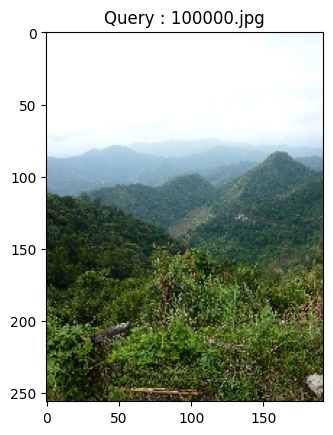

################################# Les vraies réponses ###########################


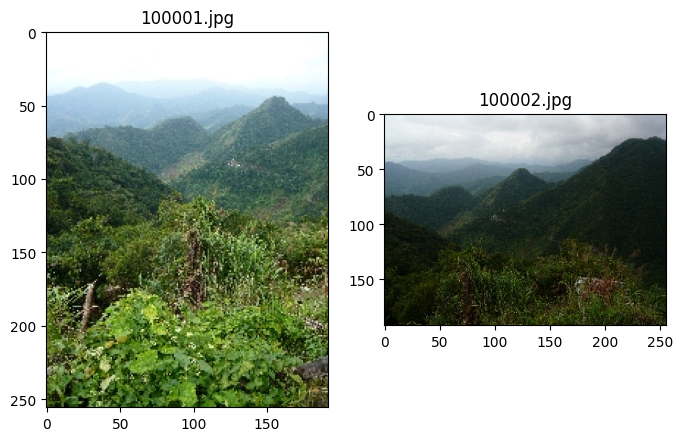

################################# Les images retrouvées ################################


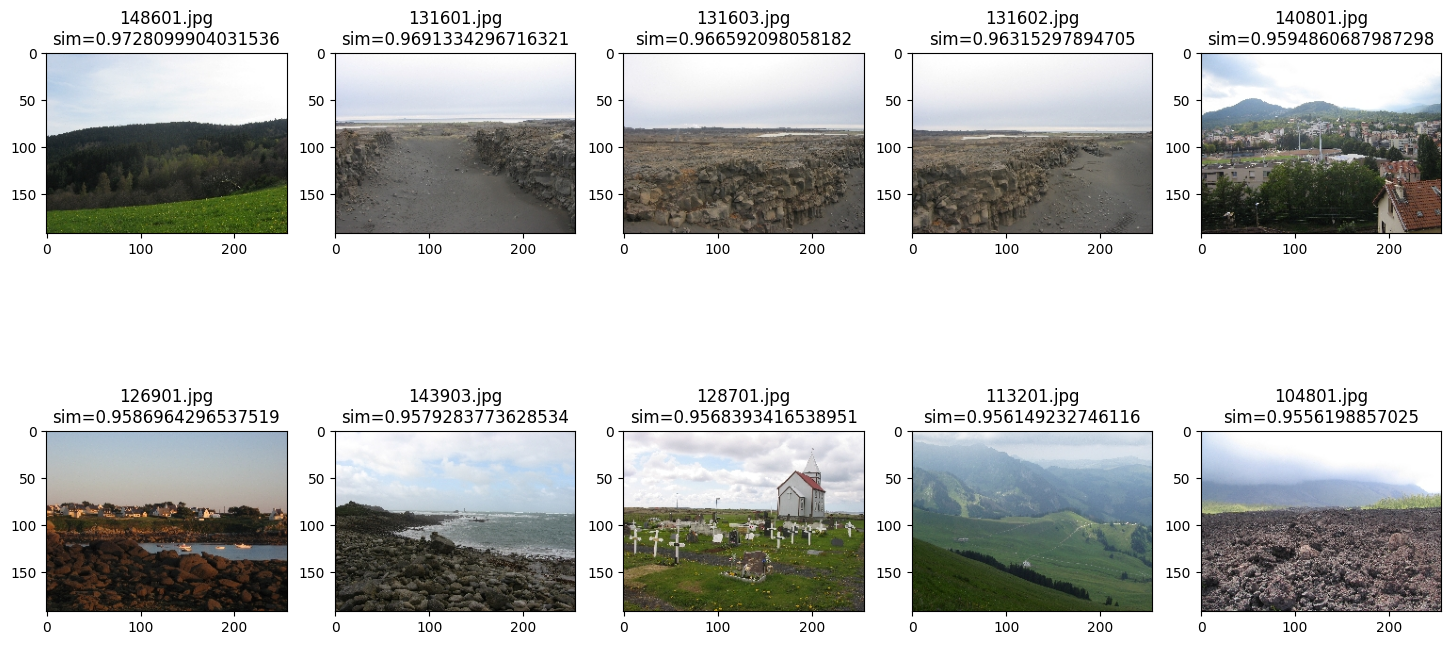

In [32]:
retreive_images(queries[0], 10, 100, 'cosine')

## Améliorer le systeme de search en utilisant des descripteurs d'images

## SIFT

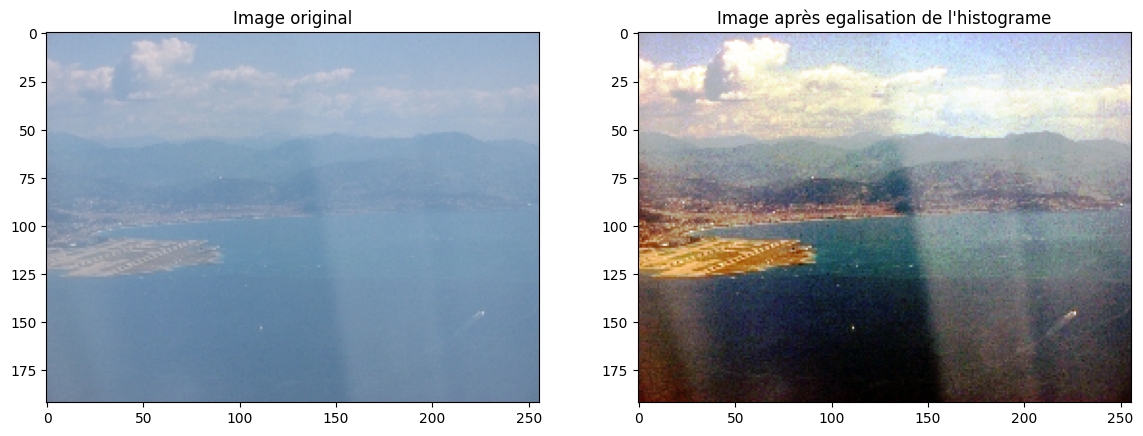

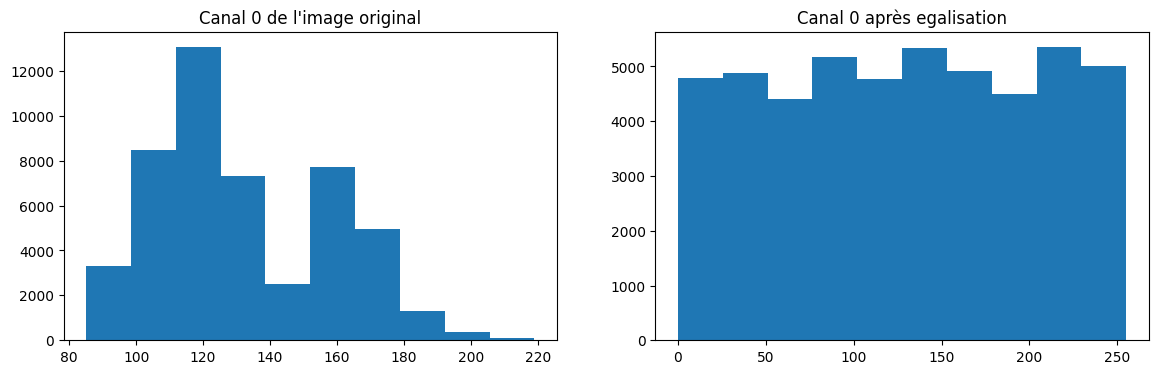

In [33]:
im = plt.imread("smallholidays/124801.jpg")
plt.figure(figsize=(14,6))
plt.subplot(121)
plt.imshow(im)
plt.title("Image original")

dst1 = cv.equalizeHist(im[:,:,0])
dst2 = cv.equalizeHist(im[:,:,1])
dst3 = cv.equalizeHist(im[:,:,2])
img = np.stack([dst1,dst2,dst3],axis=2)
plt.subplot(122)
plt.imshow(img)
plt.title("Image après egalisation de l'histograme")
plt.show()

plt.figure(figsize=(14,4))
plt.subplot(121)
_ = plt.hist(im[:,:,0].flatten())
plt.title("Canal 0 de l'image original")
plt.subplot(122)
_ = plt.hist(dst1.flatten())
plt.title("Canal 0 après egalisation")
plt.show()

In [34]:
detector = cv.SIFT_create()

img_descriptors = {}
#    
for name in tqdm(names):
    im = plt.imread("smallholidays/"+name)
    dst1 = cv.equalizeHist(im[:,:,0])
    dst2 = cv.equalizeHist(im[:,:,1])
    dst3 = cv.equalizeHist(im[:,:,2])
    img = np.stack([dst1,dst2,dst3],axis=2)
    img_descriptors[name] = detector.detectAndCompute(img, None)

  0%|          | 0/1491 [00:00<?, ?it/s]

In [36]:
matcher = cv.DescriptorMatcher_create(cv.DescriptorMatcher_FLANNBASED)
detector = cv.SIFT_create()
def sift_matcher(name,number,ratio_thresh=0.7):
    query_key,query_desc = img_descriptors[name]
    res = []
    for name in tqdm(answers):
        keys,desc = img_descriptors[name]
        knn_matches = matcher.knnMatch(query_desc, desc, 2)
        good_matches = []
        for m,n in knn_matches:
            if m.distance < ratio_thresh * n.distance:
                good_matches.append(m)
        res.append((len(good_matches),name))
    return sorted(res,key = lambda x: x[0],reverse=True)[:number]

  0%|          | 0/991 [00:00<?, ?it/s]

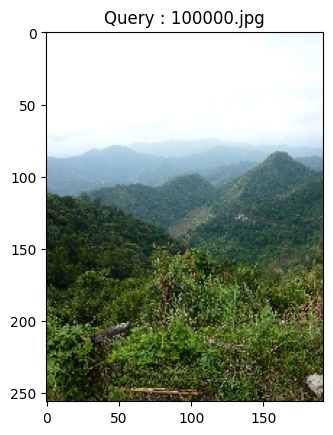

################################# Les vraies réponses ###########################


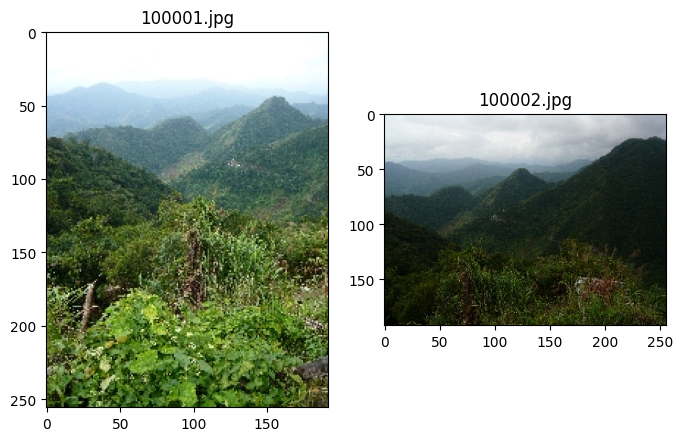

################################# Les images retrouvées ################################


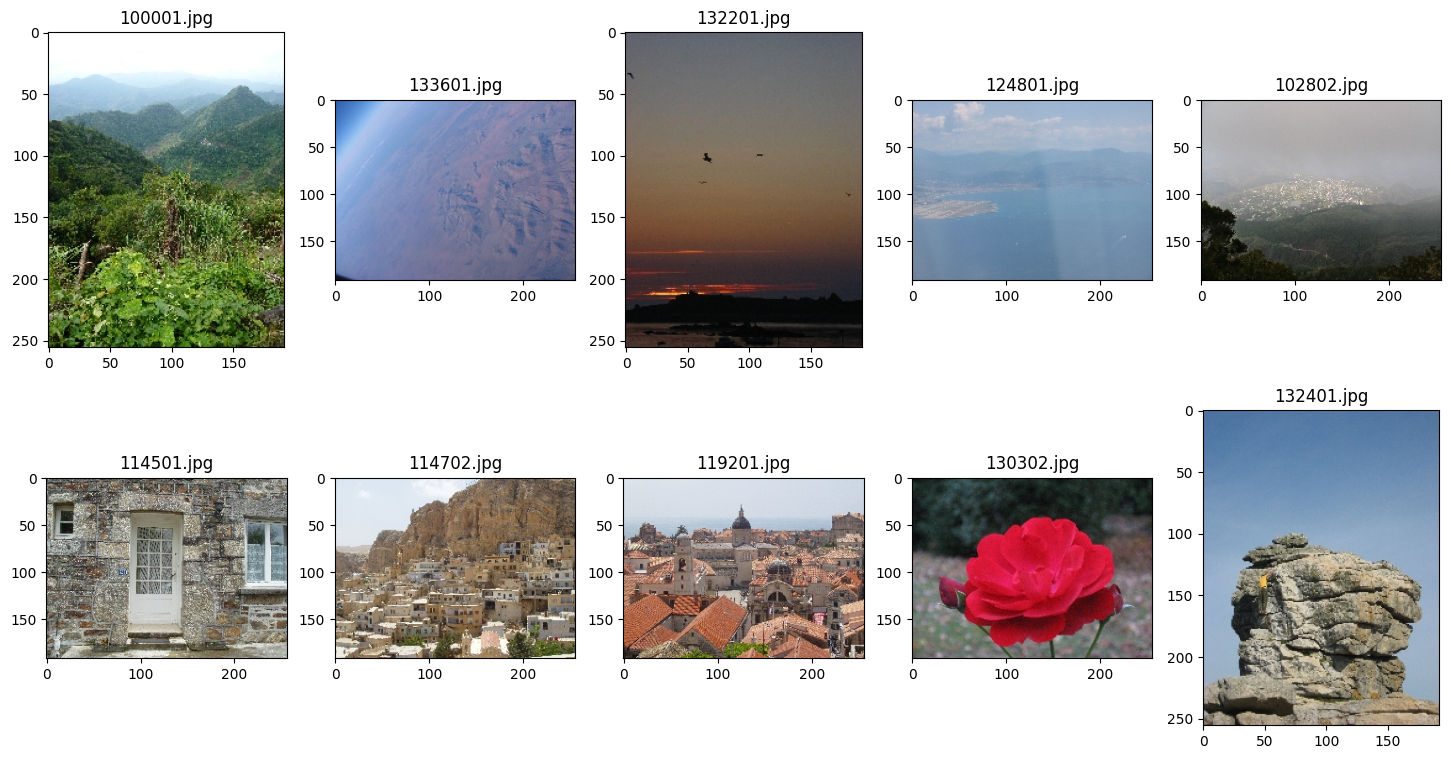

In [37]:
k = 0
number = 10
query = queries[k]
result = sift_matcher(query,10)
plt.imshow(plt.imread(os.path.join(folder_name, query)))
plt.title("Query : {}".format(query))
plt.show()

print("################################# Les vraies réponses ###########################")
gt = img_dict[query]
n = len(gt)
plt.figure(figsize=(4*n,6))
for i in range(n):
    plt.subplot(1,n,i+1)
    plt.title(gt[i])
    plt.imshow(plt.imread(os.path.join(folder_name, gt[i])))
plt.show()

print("################################# Les images retrouvées ################################")
lines = number // 5
columns = number // 2
plt.figure(figsize=(18,9))
for i in range(number):
    plt.subplot(lines,columns,i+1)
    plt.title(result[i][1])
    plt.imshow(plt.imread(os.path.join(folder_name, result[i][1])))
plt.show()

## Utilisation d'un reseau de neuronne pre entrainné

In [38]:
from torchvision.models import resnet50
import torch

In [39]:
resnet = resnet50(weights=True, progress=True)
resnet = torch.nn.Sequential(*list(resnet.children())[:-1])

C:\Users\hamdi\miniconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [41]:
# with torch.no_grad():
#     for name in tqdm(names):
#         img = plt.imread("smallholidays/"+name)
#         dst1 = cv.equalizeHist(img[:,:,0])
#         dst2 = cv.equalizeHist(img[:,:,1])
#         dst3 = cv.equalizeHist(img[:,:,2])
#         img = cv.resize(np.stack([dst1,dst2,dst3],axis=2), (224,224))
#         x = torch.moveaxis(torch.tensor(img, dtype=torch.float), 2,0)
#         x = x.unsqueeze(0)
#         torch.save(resnet(x).squeeze((2,3)), "features/"+name.split('.')[0]+'.pt')

In [42]:
def retreive_resnet(query,number,metric):
    query_features = torch.load('features/{}.pt'.format(query.split('.')[0])).numpy()
    similarities = []
    for name in tqdm(answers):
        vect = torch.load('features/{}.pt'.format(name.split('.')[0])).numpy()
        sim = 1 - cdist(query_features,vect,metric=metric)
        similarities.append((name,sim))
        
    sorted_sim = sorted(similarities,key = lambda x: x[1], reverse=True)
    plt.imshow(plt.imread(os.path.join(folder_name, query)))
    plt.title("Query : {}".format(query))
    plt.show()
    
    print("################################# Les vraies réponses ###########################")
    gt = img_dict[query]
    n = len(gt)
    plt.figure(figsize=(4*n,6))
    for i in range(n):
        plt.subplot(1,n,i+1)
        plt.title(gt[i])
        plt.imshow(plt.imread(os.path.join(folder_name, gt[i])))
    plt.show()
    
    print("################################# Les images retrouvées ################################")
    lines = number // 5
    columns = number // 2
    plt.figure(figsize=(18,9))
    for i in range(number):
        plt.subplot(lines,columns,i+1)
        plt.title(sorted_sim[i][0])
        plt.imshow(plt.imread(os.path.join(folder_name, sorted_sim[i][0])))
    plt.show()


  0%|          | 0/991 [00:00<?, ?it/s]

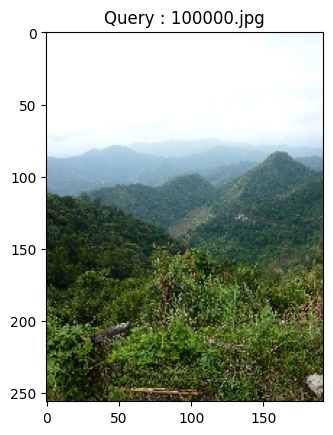

################################# Les vraies réponses ###########################


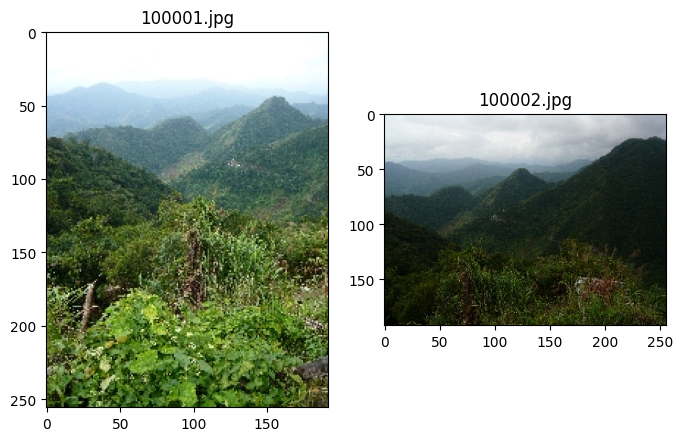

################################# Les images retrouvées ################################


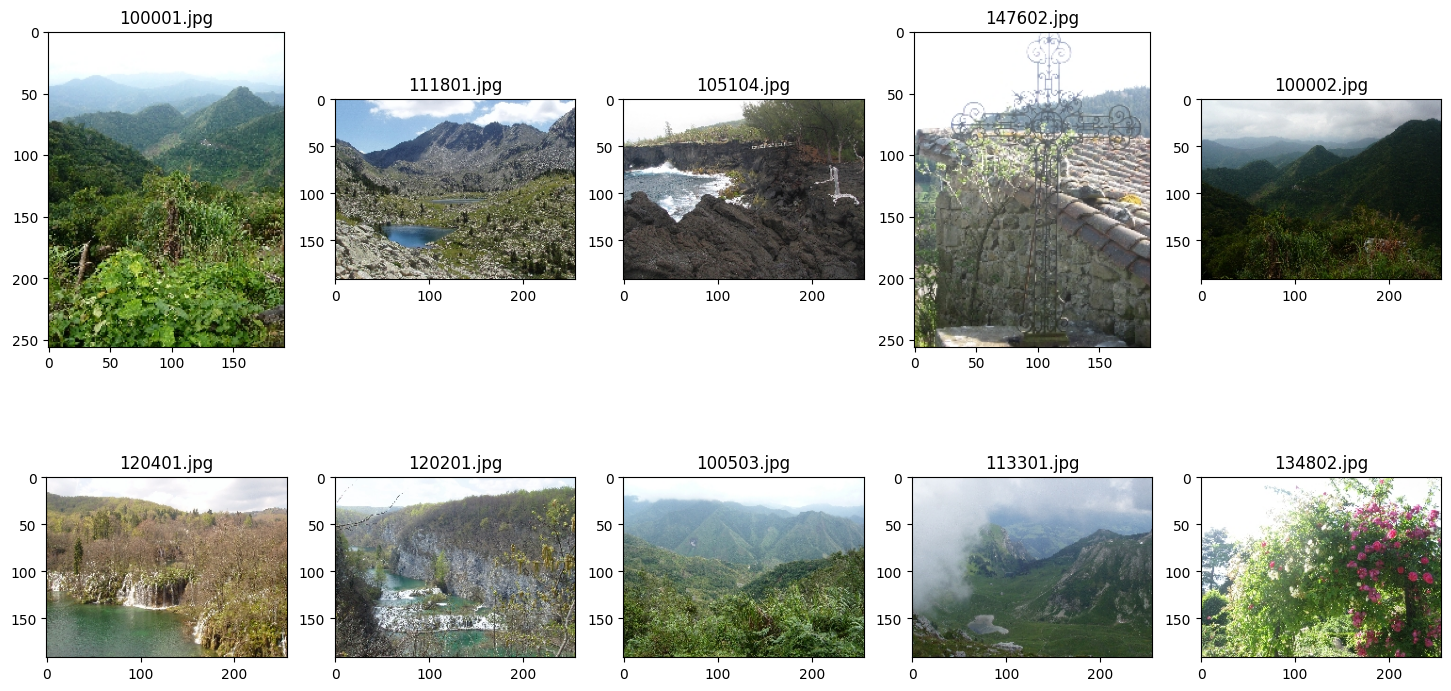

In [43]:
retreive_resnet(queries[0], 10, 'euclidean')